In [2]:
#Based on examples from the Keras documentation
import numpy as np
np.random.seed(42)
from tensorflow import keras
from tensorflow.keras import layers
import pickle

%matplotlib inline
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from glob import glob
from os.path import join, expanduser
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from ipywidgets import interact
import ipywidgets as widgets
from keras.models import Model, save_model, load_model
from keras.layers import Dense, Activation, Conv2D, Input, AveragePooling2D, MaxPooling2D, Flatten, LeakyReLU, Dropout
from keras.layers import SpatialDropout2D
from tensorflow.keras.optimizers import Adam, SGD
from keras.regularizers import l2
import keras.backend as K
from scipy.ndimage import gaussian_filter
from sklearn.metrics import mean_squared_error, roc_auc_score


num_classes = 6
input_shape = (136, 136, 1)

with open("/share/jcorner_data/pkls/1996_2011_train.pkl", "rb") as f:
    (x_train, y_train) = pickle.load(f)

with open("/share/jcorner_data/pkls/2012_2013_validation.pkl", "rb") as f:
    (x_val, y_val) = pickle.load(f)

with open("/share/jcorner_data/pkls/2014_2017_test.pkl", "rb") as f:
    (x_test, y_test) = pickle.load(f)

#Normalize by 80 dBZ
x_train = x_train.astype("float32") / 80
x_test = x_test.astype("float32") / 80
x_val = x_val.astype("float32") / 80

print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_val.shape[0], "validate samples")
print(x_test.shape[0], "test samples")

y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

modes = ['isolated_cell', 'multiple_isolated_cells', 'loosely_clustered_cells', 'tightly_clustered_cells', 'qlcs', 'other']

x_train shape: (4560, 136, 136, 1)
4560 train samples
309 validate samples
920 test samples


In [3]:
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import numpy as np


def radar_norm():
    r"""Return a colormap and normalization that allow you to represent
    radar data with colors every 5 dBZ that mimics the official NWS
    radar images.
    
    Parameters
    ----------
        
    Returns
    -------
    cmap: ListedColormap
        NWS-like radar colormap.
    norm: BoundaryNorm
        Normalization for 5 dBZ levels (0-80).
    """ 

    cmap = radar_colormap()
    classes = np.array(list(range(0, 85, 5)))
    norm = BoundaryNorm(classes, ncolors=cmap.N)    
    
    return cmap, norm


def radar_colormap():
    r"""Returns an NWS colormap.
    
    Parameters
    ----------
        
    Returns
    -------
    cmap: ListedColormap
        NWS-like radar colormap.
    """ 
 
    nws_reflectivity_colors = ["#ffffff",  # 0
                               "#04e9e7",  # 5
                               "#019ff4",  # 10
                               "#0300f4",  # 15
                               "#02fd02",  # 20
                               "#01c501",  # 25
                               "#008e00",  # 30
                               "#fdf802",  # 35
                               "#e5bc00",  # 40
                               "#fd9500",  # 45
                               "#fd0000",  # 50
                               "#d40000",  # 55
                               "#bc0000",  # 60
                               "#f800fd",  # 65
                               "#9854c6",  # 70
                               "#4B0082",  # 75
                               "#000000"]
                                
    cmap = ListedColormap(nws_reflectivity_colors)
    
    return cmap


def draw_box_plot(ax, img, cbar_shrink=0.35):
    r"""Creates a pre-packaged display for indidivual or summary
    svrimg images.  Modifies an input axis.
    
    Parameters
    ----------
    ax: matplotlib.pyplot.axes.Axes
        Modifiable matplotlib.pyplot axis.
    img: (M, N) ndarray
        SVRIMG radar image
    cbar_shrink: numeric
        Value between 0 - 1.  This will be replacedwith kwargs in 
        future for more customization. Default is 0.35.
    Returns
    -------
    ax: matplotlib.pyplot.axes.Axes
        Modified matplotlib.pyplot axis.
    """ 

    cmap, norm = radar_norm()
    mmp = ax.imshow(np.flipud(img), cmap=cmap, norm=norm)

    plt.colorbar(mmp, ax=ax, shrink=cbar_shrink, pad=0.01)
    
    return ax

In [4]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices(device_type="GPU")
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

2023-09-16 17:41:16.204304: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:952] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-16 17:41:16.204705: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:952] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-16 17:41:16.204835: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:952] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


## Simple Randy Chase Model

In [4]:
num = 24

x_train48 = x_train[:, 68-num:68+num, 68-num:68+num, :]
x_test48 = x_test[:, 68-num:68+num, 68-num:68+num, :]
x_val48 = x_val[:, 68-num:68+num, 68-num:68+num, :]

<AxesSubplot:>

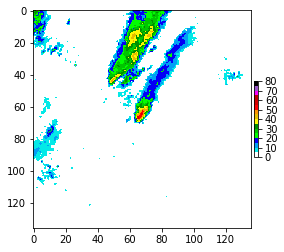

In [5]:
ax1 = plt.subplot(1,1,1)
draw_box_plot(ax1, x_train[1,:,:,0]*80)

In [7]:
model = tf.keras.models.Sequential([
        #input layer 
        tf.keras.layers.Conv2D(1,kernel_size=3,activation='relu',input_shape=(x_val.shape[1:]),),
    
        #need to flatten/ravel the 2d image into a 1d vector 
        tf.keras.layers.Flatten(),

        #add another dense layer 
        tf.keras.layers.Dense(32,activation='relu'),
    
        #output layer (apply sigmoid because binary classification
        tf.keras.layers.Dense(6,activation='softmax'),
        ])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 134, 134, 1)       10        
                                                                 
 flatten_1 (Flatten)         (None, 17956)             0         
                                                                 
 dense_2 (Dense)             (None, 32)                574624    
                                                                 
 dense_3 (Dense)             (None, 6)                 198       
                                                                 
Total params: 574,832
Trainable params: 574,832
Non-trainable params: 0
_________________________________________________________________


In [7]:
datagen = ImageDataGenerator(rotation_range=55, zoom_range=[0.9,1.0], fill_mode="reflect")

In [10]:
epochs = 100

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(datagen.flow(x_train, y_train, batch_size=32), epochs=epochs, validation_data=(x_val, y_val), workers=8)

Epoch 1/100


2023-09-11 16:44:59.900365: I tensorflow/stream_executor/cuda/cuda_dnn.cc:379] Loaded cuDNN version 8400


  3/143 [..............................] - ETA: 4s - loss: 2.6538 - accuracy: 0.1979  

2023-09-11 16:45:00.768913: I tensorflow/stream_executor/cuda/cuda_blas.cc:1804] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


143/143 [==============================] - 9s 44ms/step - loss: 1.5267 - accuracy: 0.3713 - val_loss: 1.1879 - val_accuracy: 0.5210
Epoch 2/100
143/143 [==============================] - 6s 43ms/step - loss: 1.2317 - accuracy: 0.4649 - val_loss: 1.0441 - val_accuracy: 0.5631
Epoch 3/100
143/143 [==============================] - 6s 42ms/step - loss: 1.1557 - accuracy: 0.5020 - val_loss: 0.9362 - val_accuracy: 0.6472
Epoch 4/100
143/143 [==============================] - 6s 41ms/step - loss: 1.1038 - accuracy: 0.5206 - val_loss: 0.9220 - val_accuracy: 0.6084
Epoch 5/100
143/143 [==============================] - 6s 43ms/step - loss: 1.0678 - accuracy: 0.5379 - val_loss: 0.8657 - val_accuracy: 0.6634
Epoch 6/100
143/143 [==============================] - 6s 42ms/step - loss: 1.0581 - accuracy: 0.5463 - val_loss: 0.8962 - val_accuracy: 0.6893
Epoch 7/100
143/143 [==============================] - 6s 43ms/step - loss: 1.0434 - accuracy: 0.5559 - val_loss: 0.8385 - val_accuracy: 0.6537
Epoc

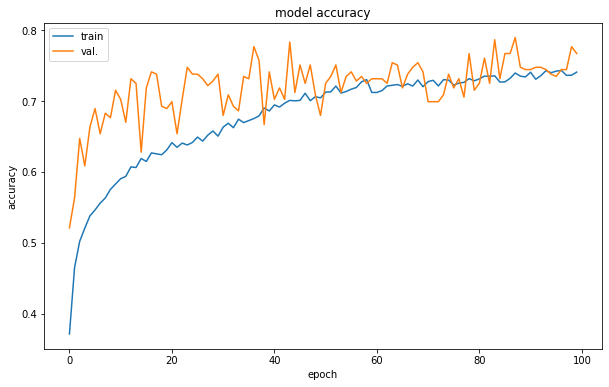

In [11]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = 10, 6

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val.'], loc='upper left')
plt.show()

In [12]:
#save the model
#model.save("/share/jcorner_data/models/morph_model_RandyChase_v06.h5")

## Suggested David Gagne Model

In [1]:
model = keras.Sequential(
    [
        keras.Input(shape=(136, 136, 1)),
        layers.Conv2D(32, kernel_size=(5, 5), activation="relu"),
        layers.Conv2D(64, kernel_size=(5, 5), activation="relu"),
        layers.AveragePooling2D(pool_size=(2, 2)),
        layers.Conv2D(128, kernel_size=(5, 5), activation="relu"),
        layers.AveragePooling2D(pool_size=(2, 2)),
        layers.Dense(128, activation="relu"),
        layers.Flatten(),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

NameError: name 'keras' is not defined

In [12]:
epochs = 15

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(datagen.flow(x_train, y_train, batch_size=128), epochs=epochs, validation_data=(x_val, y_val), workers=8)

Epoch 1/15
36/36 [==============================] - 7s 160ms/step - loss: 1.2567 - accuracy: 0.4706 - val_loss: 0.9194 - val_accuracy: 0.6181
Epoch 2/15
36/36 [==============================] - 7s 149ms/step - loss: 0.9435 - accuracy: 0.6066 - val_loss: 1.3256 - val_accuracy: 0.5437
Epoch 3/15
36/36 [==============================] - 7s 145ms/step - loss: 0.8168 - accuracy: 0.6618 - val_loss: 0.8371 - val_accuracy: 0.5987
Epoch 4/15
36/36 [==============================] - 6s 137ms/step - loss: 0.6766 - accuracy: 0.7303 - val_loss: 0.9675 - val_accuracy: 0.5696
Epoch 5/15
36/36 [==============================] - 6s 148ms/step - loss: 0.6215 - accuracy: 0.7529 - val_loss: 0.7142 - val_accuracy: 0.6667
Epoch 6/15
36/36 [==============================] - 7s 144ms/step - loss: 0.5494 - accuracy: 0.7822 - val_loss: 0.4820 - val_accuracy: 0.8091
Epoch 7/15
36/36 [==============================] - 8s 149ms/step - loss: 0.5339 - accuracy: 0.7982 - val_loss: 0.7566 - val_accuracy: 0.6311
Epoch 

In [13]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.32488662004470825
Test accuracy: 0.8782608509063721


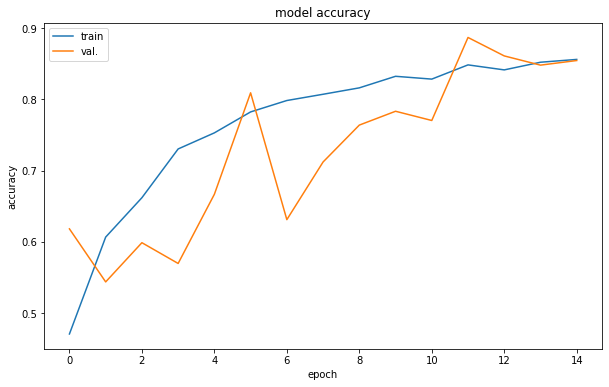

In [14]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = 10, 6

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val.'], loc='upper left')
plt.show()